In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Обучать модели можно по отдельным elo, по разнице и среднему

In [3]:
elos = pd.read_csv(r'C:\Users\Asus\PredictingRatings\data\elos.csv')
elos['MeanElos']=elos.mean(axis=1).astype(int)
elos['DiffElos']=abs(elos.WhiteElo-elos.BlackElo).astype(int)
# сумма рейтингов задает общее качество партии
elos['SumElos']=abs(elos.WhiteElo+elos.BlackElo).astype(int)
print(elos.describe())
elos.head()

           WhiteElo      BlackElo      MeanElos      DiffElos       SumElos
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000
mean    2246.851040   2241.891320   2244.120760    189.082440   4488.742360
std      268.384897    270.983649    243.209379    136.337923    486.423841
min     1021.000000   1128.000000   1216.000000      0.000000   2433.000000
25%     2075.000000   2067.000000   2090.000000     88.000000   4181.000000
50%     2272.000000   2267.000000   2266.000000    165.000000   4532.000000
75%     2447.000000   2447.000000   2421.000000    259.000000   4843.000000
max     2864.000000   2881.000000   2840.000000   1267.000000   5681.000000


,WhiteElo,BlackElo,MeanElos,DiffElos,SumElos
0,2354,2411,2382,57,4765
1,2523,2460,2491,63,4983
2,1915,1999,1957,84,3914
3,2446,2191,2318,255,4637
4,2168,2075,2121,93,4243


In [4]:
elos_reject=elos[(elos['BlackElo']<1200)|(elos['WhiteElo']<1200)]
elos_reject.head()

,WhiteElo,BlackElo,MeanElos,DiffElos,SumElos
790,1968,1172,1570,796,3140
1428,1021,2135,1578,1114,3156
4367,1680,1128,1404,552,2808
6774,1172,1576,1374,404,2748
8788,1142,1447,1294,305,2589


In [5]:
elos = elos[~elos.index.isin(elos_reject.index)]
elos.shape

(24987, 5)

In [7]:
games= pd.read_csv(r'C:\Users\Asus\PredictingRatings\data\games.csv')
games.Scores=games.Scores.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.Scores=games.Scores.apply(lambda x: list(map(int,x.split())))
games.Moves=games.Moves.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.Moves=games.Moves.apply(lambda x: x.split())
games.UCI=games.UCI.str.replace(' ','').str.replace('[','').str.replace(']','').str.replace(',',' ')
games.UCI=games.UCI.apply(lambda x: x.split())
games.head()

,Result,Moves,UCI,Scores,NumMoves
0,1/2-1/2,"['Nf3', 'Nf6', 'c4', 'c5', 'b3', 'g6', 'Bb2', ...","['g1f3', 'g8f6', 'c2c4', 'c7c5', 'b2b3', 'g7g6...","[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,...",19
1,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Nxe5...","['e2e4', 'e7e5', 'g1f3', 'g8f6', 'd2d4', 'f6e4...","[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5...",7
2,0-1,"['e4', 'd5', 'exd5', 'Nf6', 'd4', 'Nxd5', 'Nf3...","['e2e4', 'd7d5', 'e4d5', 'g8f6', 'd2d4', 'f6d5...","[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5...",53
3,1-0,"['c4', 'Nf6', 'Nc3', 'd6', 'd4', 'e5', 'Nf3', ...","['c2c4', 'g8f6', 'b1c3', 'd7d6', 'd2d4', 'e7e5...","[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ...",39
4,1-0,"['e4', 'c5', 'Nf3', 'd6', 'b4', 'Nf6', 'bxc5',...","['e2e4', 'c7c5', 'g1f3', 'd7d6', 'b2b4', 'g8f6...","[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9...",25


#### Данные без рейтинга (submissions к соревнованию) не помогут для реализации модели

In [8]:
games = games[games.index.isin(elos.index)]
games.shape

(24987, 5)

In [9]:
games_small=games[games['NumMoves']<10]
games_small

,Result,Moves,UCI,Scores,NumMoves
1,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Nxe5...","['e2e4', 'e7e5', 'g1f3', 'g8f6', 'd2d4', 'f6e4...","[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5...",7
44,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nc6', 'Bb5', 'a5', 'Bxc6'...","['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1b5', 'a7a5...","[26, 45, 26, 20, 30, 68, 29, 38, 47, 39]",5
251,1/2-1/2,"['d4', 'Nf6', 'Nf3', 'e6', 'g3', 'b5', 'Bg2', ...","['d2d4', 'g8f6', 'g1f3', 'e7e6', 'g2g3', 'b7b5...","[19, 17, 8, 21, -5, 42, 22, 14, 18, 43, 29, 36...",8
308,1-0,"['d4', 'd5', 'Bf4', 'Nf6']","['d2d4', 'd7d5', 'c1f4', 'g8f6']","[19, 13, 16, 16]",2
556,1/2-1/2,"['Nf3', 'Nf6', 'g3', 'g6', 'b3', 'Bg7', 'Bb2',...","['g1f3', 'g8f6', 'g2g3', 'g7g6', 'b2b3', 'f8g7...","[18, 11, -4, 20, -15, -11, -12, -20, -16, 14, ...",8
624,1-0,['e4'],['e2e4'],[],1
762,1/2-1/2,"['d4', 'd5', 'Nf3', 'Nf6', 'e3', 'e6', 'Bd3', ...","['d2d4', 'd7d5', 'g1f3', 'g8f6', 'e2e3', 'e7e6...","[19, 13, 10, 22, 15, 8, 13, 13, 5, 2, 10, 16, ...",7
828,1/2-1/2,"['e4', 'e5', 'Nf3']","['e2e4', 'e7e5', 'g1f3']","[13, 44, 26]",2
929,1/2-1/2,"['e4', 'e6', 'd4', 'd5', 'exd5', 'exd5', 'Nf3'...","['e2e4', 'e7e6', 'd2d4', 'd7d5', 'e4d5', 'e6d5...","[26, 48, 46, 29, 23, 7, 23, 24, 14, 25, 27, 51...",8
943,1/2-1/2,"['c4', 'c5', 'Nc3', 'Nc6', 'Nf3', 'Nf6', 'g3',...","['c2c4', 'c7c5', 'b1c3', 'b8c6', 'g1f3', 'g8f6...","[2, 26, 12, 7, 23, 22, -3, 14, 22, 29, 28, 29, 7]",7


In [10]:
games = games[~games.index.isin(games_small.index)]
games.shape

(24753, 5)

In [11]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24753 entries, 0 to 24999
Data columns (total 5 columns):
Result      24753 non-null object
Moves       24753 non-null object
UCI         24753 non-null object
Scores      24753 non-null object
NumMoves    24753 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


#### Добавление некоторых признаков для удаления выбросов

In [15]:
games['MeanScore']=games.Scores.apply(lambda x: np.mean(x))
games['ModeScore']=games.Scores.apply(lambda x: max(set(x), key=x.count))
games['FinalScore']=games.Scores.apply(lambda x: x[-1])
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24753 entries, 0 to 24999
Data columns (total 8 columns):
Result        24753 non-null object
Moves         24753 non-null object
UCI           24753 non-null object
Scores        24753 non-null object
NumMoves      24753 non-null int64
MeanScore     24753 non-null float64
ModeScore     24753 non-null int64
FinalScore    24753 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.7+ MB


In [16]:
games_draws=games[games['Result']=='1/2-1/2']
games_draws.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,7596.000000,7596.000000,7596.000000,7596.000000
mean,41.021590,15.327613,6.514613,6.050948
std,19.755492,57.456467,55.127313,292.943590
min,10.000000,-1854.552381,-3980.000000,-10770.000000
25%,26.000000,-4.458097,0.000000,0.000000
50%,39.000000,15.714286,0.000000,0.000000
75%,52.250000,35.390734,10.000000,12.000000
max,165.000000,1000.052083,930.000000,10289.000000


Удаляем ничейные партии, где оценка конечной позиции слишком высокая

In [17]:
games_draws_reject=games_draws[(abs(games_draws['FinalScore'])>1000)]
games_draws_reject.head()

,Result,Moves,UCI,Scores,NumMoves,MeanScore,ModeScore,FinalScore
67,1/2-1/2,"['e4', 'e6', 'd4', 'd5', 'exd5', 'exd5', 'Bd3'...","['e2e4', 'e7e6', 'd2d4', 'd7d5', 'e4d5', 'e6d5...","[26, 48, 46, 29, 23, 7, 16, 22, 1, 14, -12, -2...",53,116.698113,0,10289
1400,1/2-1/2,"['d4', 'd5', 'c4', 'c6', 'Nf3', 'Nf6', 'Nc3', ...","['d2d4', 'd7d5', 'c2c4', 'c7c6', 'g1f3', 'g8f6...","[19, 13, 9, 34, 45, 40, 41, 37, 20, 41, 43, 46...",69,8.014599,0,-4926
2223,1/2-1/2,"['d4', 'd6', 'c4', 'e5', 'Nf3', 'e4', 'Ng5', '...","['d2d4', 'd7d6', 'c2c4', 'e7e5', 'g1f3', 'e5e4...","[19, 42, 38, 27, 39, 17, -12, -16, 18, -10, 29...",63,73.150794,0,5403
2319,1/2-1/2,"['Nf3', 'g6', 'c4', 'Bg7', 'd4', 'd6', 'Nc3', ...","['g1f3', 'g7g6', 'c2c4', 'f8g7', 'd2d4', 'd7d6...","[18, 82, 43, 31, 53, 42, 50, 55, 56, 73, -11, ...",49,-106.173469,0,-1651
2459,1/2-1/2,"['e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nf6', 'd3',...","['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1c4', 'g8f6...","[26, 44, 25, 14, 19, 15, 12, 19, 0, 0, -3, 37,...",41,-73.024691,0,-1266


In [18]:
games = games[~games.index.isin(games_draws_reject.index)]
games.shape

(24727, 8)

Удаляем результативные партии, где меньше 20 ходов и низкая оценка финальной позиции (вероятно нарушение правил или другое обстоятельство, не влияющее на качество игры)

In [19]:
games_reject=games[(games['NumMoves']<20)
                         &((games['Result']=='1-0')| (games['Result']=='0-1'))
                         &(abs(games['FinalScore'])<50)]
games_reject.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,32.000000,32.000000,32.000000,32.000000
mean,14.687500,23.259583,13.375000,7.187500
std,3.207225,24.770213,20.370361,20.480419
min,10.000000,-34.454545,-46.000000,-35.000000
25%,12.000000,14.848684,1.000000,-3.750000
50%,15.000000,19.542857,11.000000,3.000000
75%,18.000000,30.511538,20.250000,17.750000
max,19.000000,122.970588,84.000000,49.000000


In [20]:
games = games[~games.index.isin(games_reject.index)]
games.shape

(24695, 8)

Удаляем ничейные партии с количеством ходов меньше 15 (скорее всего договорные)

In [21]:
games_draws_moves_reject=games_draws[games_draws['NumMoves']<15]
games_draws_moves_reject.shape

(440, 8)

In [22]:
games = games[~games.index.isin(games_draws_moves_reject.index)]
games.shape

(24255, 8)

In [23]:
games.describe()

,NumMoves,MeanScore,ModeScore,FinalScore
count,24255.000000,24255.000000,24255.000000,24255.000000
mean,42.252690,30.881103,11.907442,111.901711
std,16.235593,233.709202,445.214702,2310.851869
min,10.000000,-2162.262500,-11447.000000,-12261.000000
25%,31.000000,-60.758665,0.000000,-362.000000
50%,40.000000,24.563636,0.000000,0.000000
75%,51.000000,123.987715,26.000000,546.500000
max,165.000000,2073.289256,11259.000000,12337.000000


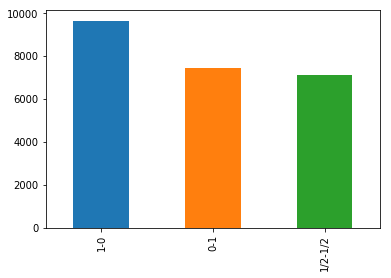

In [24]:
games['Result'].value_counts().plot('bar')

In [25]:
elos = elos[elos.index.isin(games.index)]
elos.shape

(24255, 5)

Белые в данном наборе выигрывали чаще

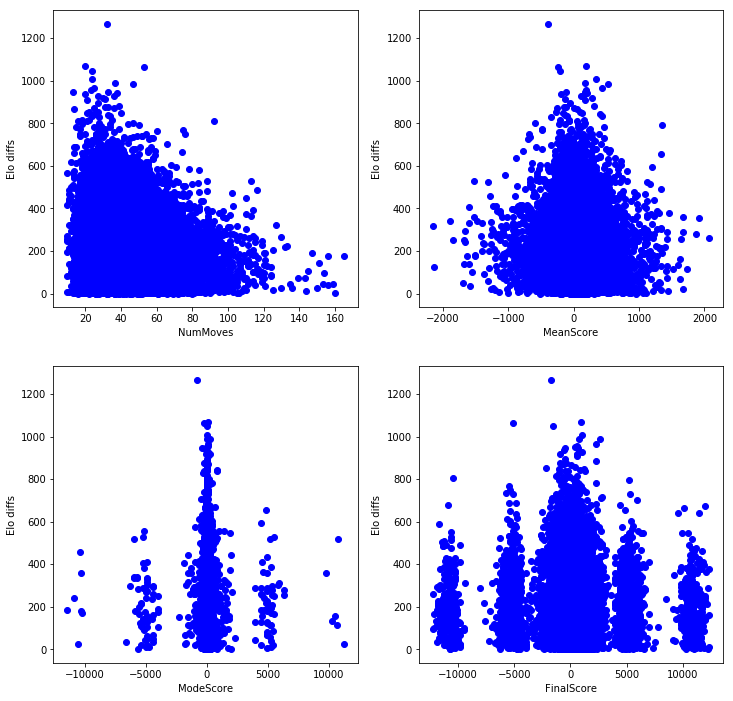

In [29]:
fig=plt.figure(figsize=(12,12))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+4], elos.DiffElos, color = 'b')
    xl=games.columns[plot_number+4]
    plt.xlabel (xl)
    plt.ylabel ("Elo diffs")
    plot_number += 1
plt.show()

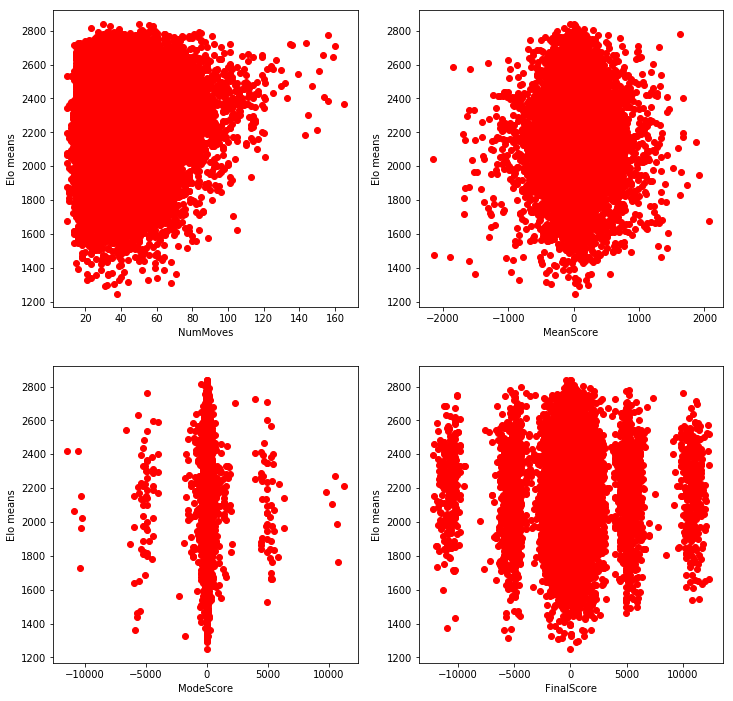

In [30]:
fig=plt.figure(figsize=(12,12))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+4], elos.MeanElos, color = 'r')
    xl=games.columns[plot_number+4]
    plt.xlabel (xl)
    plt.ylabel ("Elo means")
    plot_number += 1
plt.show()

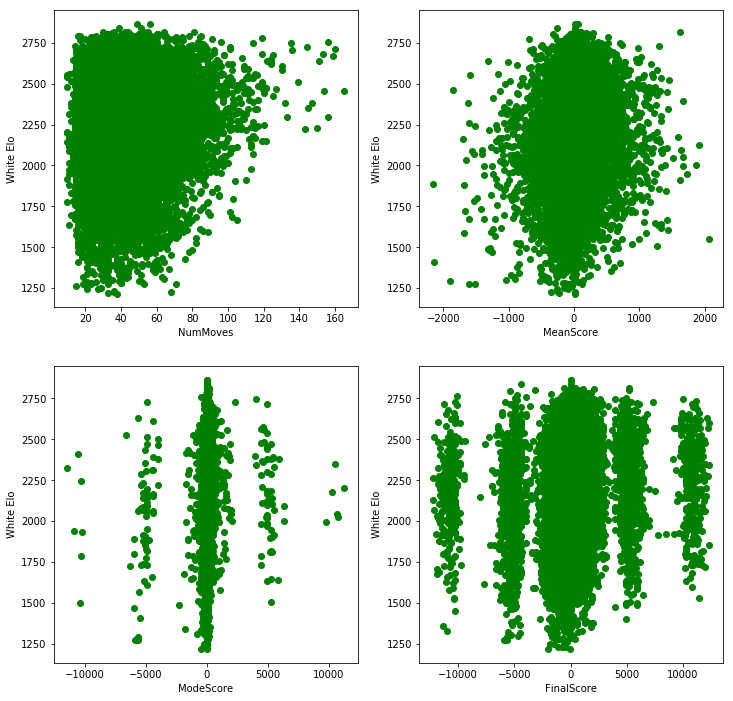

In [34]:
fig=plt.figure(figsize=(12,12))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+4], elos.WhiteElo, color = 'g')
    xl=games.columns[plot_number+4]
    plt.xlabel (xl)
    plt.ylabel ("White Elo")
    plot_number += 1
plt.show()

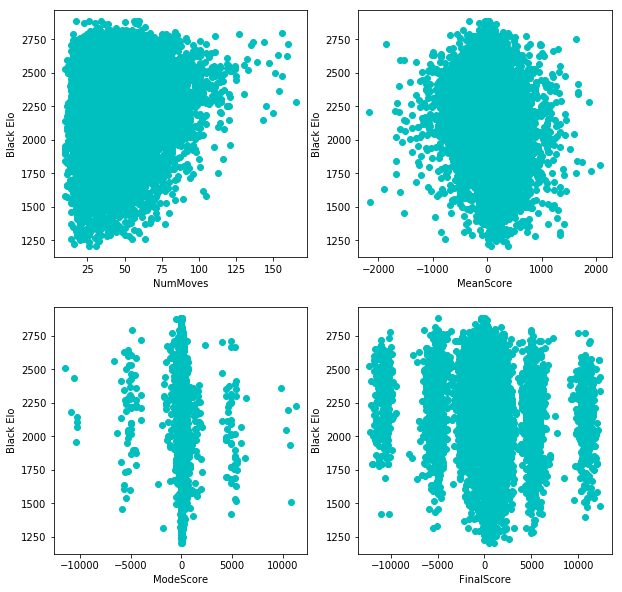

In [41]:
# Благодаря построению этих графиков, было найдено, что есть выбросы по рейтингу черных
fig=plt.figure(figsize=(10,10))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+4], elos.BlackElo, color = 'c')
    xl=games.columns[plot_number+4]
    plt.xlabel (xl)
    plt.ylabel ("Black Elo")
    plot_number += 1
plt.show()


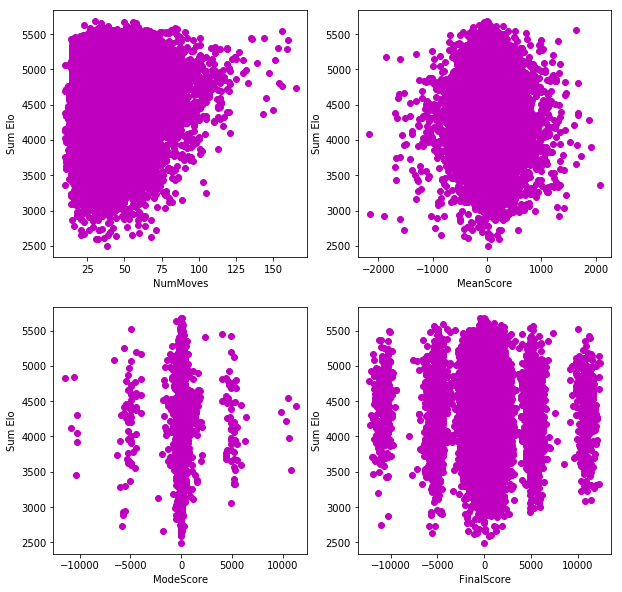

In [39]:
fig=plt.figure(figsize=(10,10))
plot_number=0
for i in range(4):
    plt.subplot(2, 2, plot_number + 1)
    plt.scatter(games.iloc[:,plot_number+4], elos.SumElos, color = 'm')
    xl=games.columns[plot_number+4]
    plt.xlabel (xl)
    plt.ylabel ("Sum Elo")
    plot_number += 1
plt.show()


В среднем наблюдается, что количество ходов коррелирует с мастерством игроков.

In [43]:
sns.pairplot(games)


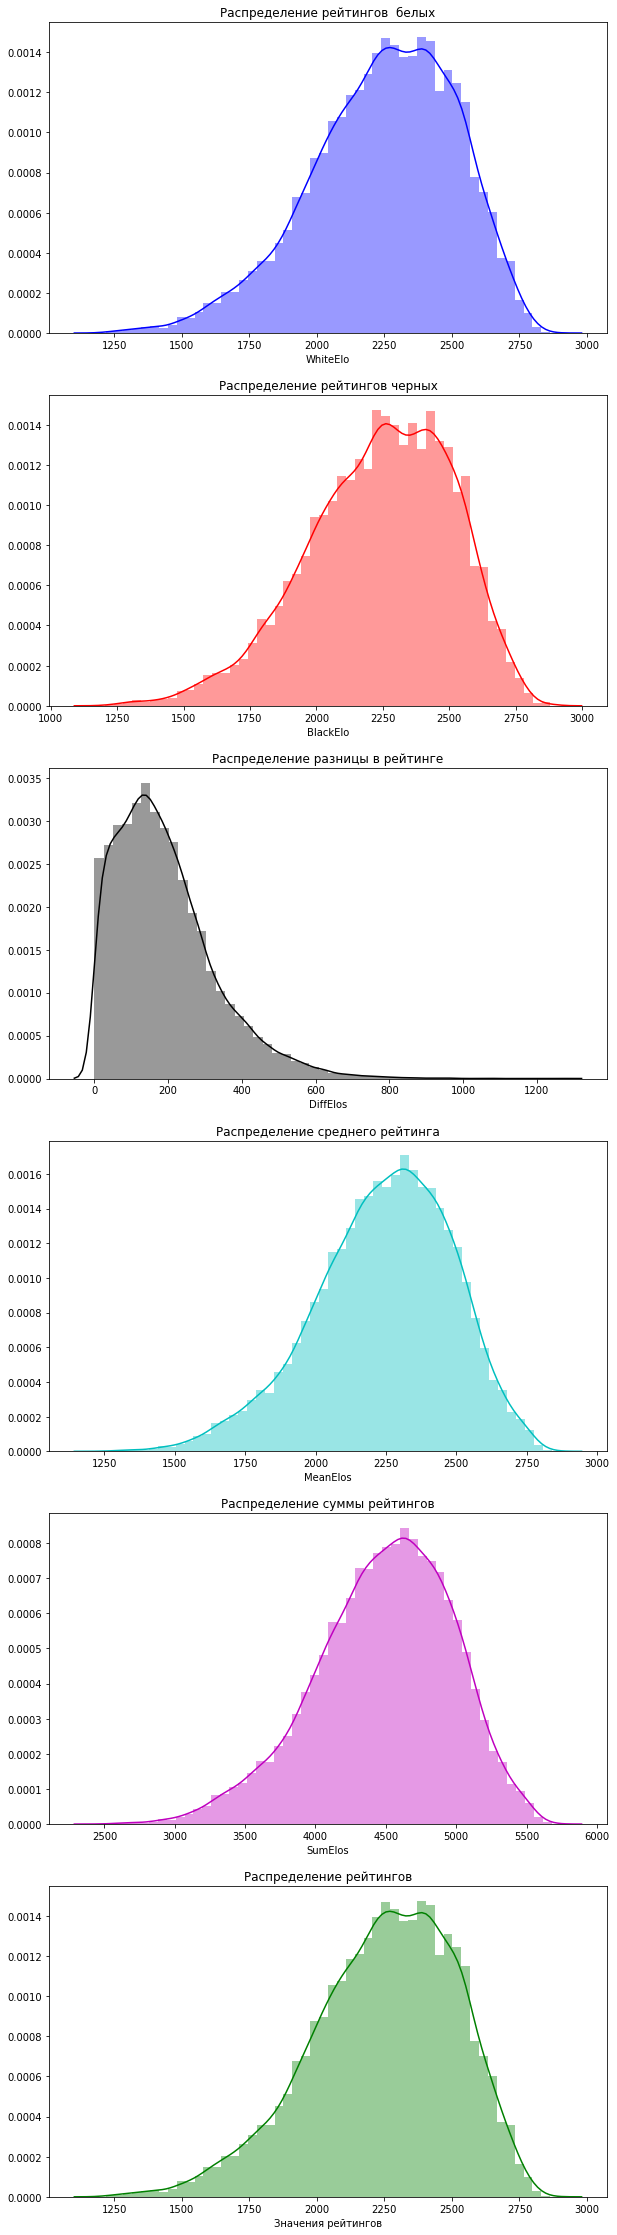

In [45]:
fig=plt.figure(figsize=(10,40))

ax1=plt.subplot(6,1,1)
sns.distplot(elos.WhiteElo,color='b')
ax1.set_title('Распределение рейтингов  белых')

ax2=plt.subplot(6,1,2)
sns.distplot(elos.BlackElo,color='r')
ax2.set_title('Распределение рейтингов черных')

ax3=plt.subplot(6,1,3)
sns.distplot(elos.DiffElos,color='k')
ax3.set_title('Распределение разницы в рейтинге')

ax4=plt.subplot(6,1,4)
sns.distplot(elos.MeanElos,color='c')
ax4.set_title('Распределение среднего рейтинга')

ax5=plt.subplot(6,1,5)
sns.distplot(elos.SumElos,color='m')
ax5.set_title('Распределение суммы рейтингов')

allElos=elos.WhiteElo
allElos.append(elos.BlackElo)
ax6=plt.subplot(6,1,6)
sns.distplot(allElos,color='g')
ax6.set_title('Распределение рейтингов')
ax6.set_xlabel("Значения рейтингов")
plt.show()

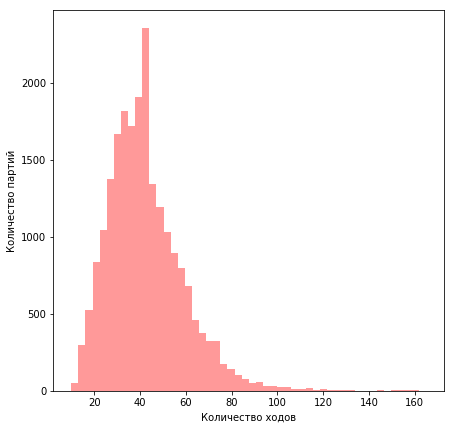

In [32]:
fig=plt.figure(figsize=(7,7))
sns.distplot(games.NumMoves,color='r',kde=False)
plt.ylabel('Количество партий')
plt.xlabel('Количество ходов')
plt.show()

In [33]:
games.to_csv(r'C:\Users\Asus\PredictingRatings\data\clean_games.csv', sep=',',index=False)
elos.to_csv(r'C:\Users\Asus\PredictingRatings\data\clean_elos.csv', sep=',',index=False)